# October’s code club 

Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import fafbseg
import navis

1. Get PNs from the FlyWire dataset (fafbseg.flywire.get_annotations('cambridge_celltypes') - if there is no R version of this command let me know and I can send the relevant data).
   - Prune/simplify as you want.
   - Split into cell_types and L/Rs (the last letter in cell_types column in the return from get_annotations is either L or R).

In [2]:
pn_annos = fafbseg.flywire.get_annotations('cambridge_celltypes')
types = np.asarray([i.split('_') for i in pn_annos.cell_type])[:,1]
pn_side = pn_annos.cell_type.str.strip().str[-1]
pn_annos['type'] = types
pn_annos['side'] = pn_side
# pn_ls = pn_annos[pn_side=='L']
# pn_rs = pn_annos[pn_side=='R']

In [3]:
selected = types[3]
print(selected)

lPN


In [4]:
# pn_annos.to_clipboard(excel=True)

2. Get neurons downstream of each PN neurons (fetch_connectivity).
   - Make histograms of connection strengths (threshold as seems relevant) for all cell types in left and right (separate graphs as you see fit).
   - For one of the cell types, on both left and right, plot the connection strength vs average distance (including std. dev bars) from soma (of the PN neurons) to pre-synapse location (use fetch_synapses to get x, y, z location of pre-synapse) for both L and R.

In [5]:
connect_table = fafbseg.flywire.synapses.fetch_connectivity(
    list(pn_annos.pt_root_id)[0], 
    clean = True, 
    upstream = False)

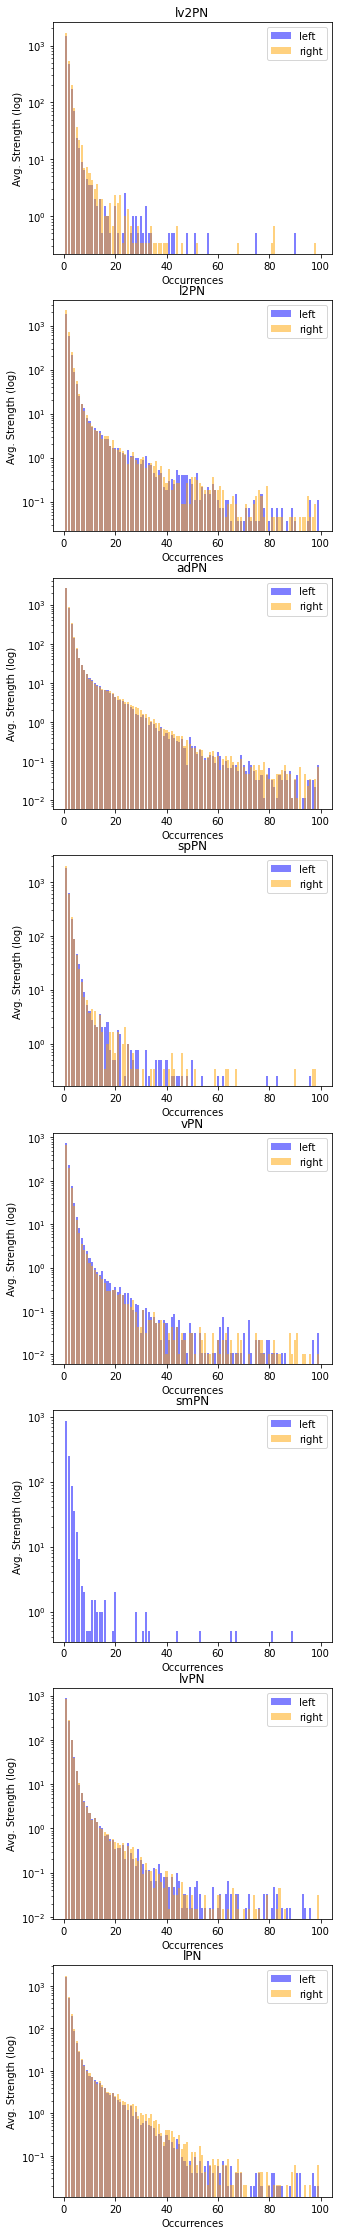

In [7]:
fig, axs = plt.subplots(8)
x_axis = np.arange(1,100)
loc = -1
for curr_type in set(types):
    loc += 1
    l_els = 1
    r_els = 1
    
    l_conns = np.zeros(99)
    r_conns = np.zeros(99)
    in_type = pn_annos[pn_annos.type == curr_type]
    in_l = in_type[in_type.side == 'L']
    in_r = in_type[in_type.side == 'R']

    for i in in_l.conns:
        l_conns = np.add(l_conns, np.asarray(i))
        l_els += 1
    for i in in_r.conns:
        r_conns = np.add(r_conns, np.asarray(i))
        r_els += 1
    
    if r_els == 1 and l_els == 1:
        loc-=1
        continue
    
    l_conns = np.divide(l_conns, l_els)
    r_conns = np.divide(r_conns, r_els)
    axs[loc].set_yscale('log')
    axs[loc].bar(x_axis, l_conns, alpha=.5, label='left', color='blue')
    axs[loc].bar(x_axis, r_conns, alpha=.5, label='right', color='orange')
    axs[loc].set_title(curr_type)
    
    axs[loc].legend()
    axs[loc].set_ylabel('Avg. Strength (log)')
    axs[loc].set_xlabel('Occurrences')
    
fig.set_figheight(40)
fig.set_figwidth(5)
plt.savefig('Oct12_2a.png', dpi=600)

In [8]:
selected_type = 'vPN'

In [9]:
sel_neurs = pn_annos[pn_annos.type==selected_type]
sel_neurs_l = sel_neurs[sel_neurs.side=='L']
sel_neurs_r = sel_neurs[sel_neurs.side=='R']
sel_roots_l = sel_neurs_l.pt_root_id
sel_roots_r = sel_neurs_r.pt_root_id

In [12]:
somas_l = fafbseg.flywire.get_somas(sel_roots_l)
somas_r = fafbseg.flywire.get_somas(sel_roots_r)

In [88]:
col_list = ['root', 'post', 'strength', 'avg_dist', 'std_dev']
l_data = pd.DataFrame(columns=col_list)
for ind in tqdm(somas_l.index): ## iterate through each soma --> get rood id
    root = somas_l.pt_root_id[ind] ## gets pre root id
    soma_loc = somas_l.pt_position[ind]
    soma_syns = syns_l[syns_l.pre == root] ## limit to just pre_root id in the syns dfs
    all_posts = set(soma_syns.post) ## get set of posts from ^
    temp = []
    for post in all_posts: ## for each post:
        curr_syns = soma_syns[soma_syns.post == post]## limit syns to just the post
        strength = curr_syns.shape[0]## count size for strength            
        post_dists = [distance.euclidean(np.multiply(soma_loc, [4,4,40]), 
                                        np.multiply([syns_l.pre_x[i], syns_l.pre_y[i], syns_l.pre_z[i]], [4,4,40]))
                                        for i in curr_syns.index] ## get the mean and std dev from each distribution here
        temp.append([root, post, strength, np.mean(post_dists), np.std(post_dists)])
#         print(temp[-1])
#         l_data.append([root, post, strength, np.mean(post_dists), np.std(post_dists)])
        ## store count, mean, std dev all nicely
    l_data = l_data.append(pd.DataFrame(temp, columns=col_list))

  0%|          | 0/92 [00:00<?, ?it/s]

In [90]:
r_data = pd.DataFrame(columns=col_list)
for ind in tqdm(somas_r.index): ## iterate through each soma --> get rood id
    root = somas_r.pt_root_id[ind] ## gets pre root id
    soma_loc = somas_r.pt_position[ind]
    soma_syns = syns_r[syns_r.pre == root] ## limit to just pre_root id in the syns dfs
    all_posts = set(soma_syns.post) ## get set of posts from ^
    temp = []
    for post in all_posts: ## for each post:
        curr_syns = soma_syns[soma_syns.post == post]## limit syns to just the post
        strength = curr_syns.shape[0]## count size for strength            
        post_dists = [distance.euclidean(np.multiply(soma_loc, [4,4,40]), 
                                        np.multiply([syns_r.pre_x[i], syns_r.pre_y[i], syns_r.pre_z[i]], [4,4,40]))
                                        for i in curr_syns.index] ## get the mean and std dev from each distribution here
        temp.append([root, post, strength, np.mean(post_dists), np.std(post_dists)])
#         print(temp[-1])
#         l_data.append([root, post, strength, np.mean(post_dists), np.std(post_dists)])
        ## store count, mean, std dev all nicely
    r_data = r_data.append(pd.DataFrame(temp, columns=col_list))

  0%|          | 0/94 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Connection Strength vs Avg. Euclidean Dist from Soma to Pre-Synapse')

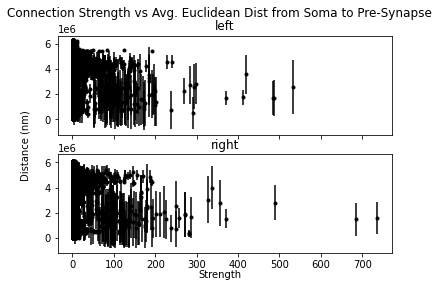

In [100]:
fig, axs = plt.subplots(2, sharex=True, sharey=True)

axs[0].errorbar(l_data.strength, l_data.avg_dist, yerr = l_data.std_dev, fmt='.k')
# axs[0].set_ylabel('Avg. Distance To Synapse from Soma (nm)')
# axs[0].set_xlabel('Strength')
axs[0].set_title('left')

axs[1].errorbar(r_data.strength, r_data.avg_dist, yerr = r_data.std_dev, fmt='.k')
# axs[1].set_ylabel('Avg. Distance To Synapse from Soma')
# axs[1].set_xlabel('Strength')
axs[1].set_title('right')

fig.text(0.04, 0.5, 'Distance (nm)', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Strength', ha='center')

fig.suptitle('Connection Strength vs Avg. Euclidean Dist from Soma to Pre-Synapse')
# axs[0].set_yscale('log')
# axs[1].set_yscale('log')
# axs[0].set_xscale('log')
# axs[1].set_xscale('log')

3. Find the most likely neurotransmitter for each PN neuron.
   - Plot the average number of synapses (w/ std. dev bars) for each NT.
   - Plot the average connection strength (w/ std. dev bars) for each NT.

In [158]:
l = {}
for i in np.arange(0,673,8):
    l = l|pn_annos.NT[i]

pn_annos.NT = np.asarray(list(l.values()))[:,0]

{720575940628504919: ('acetylcholine', 0.8903185109252281),
 720575940621572615: ('acetylcholine', 0.9065025305004488),
 720575940621515305: ('acetylcholine', 0.9115716461923921),
 720575940621384328: ('acetylcholine', 0.9584912922050132),
 720575940615084683: ('acetylcholine', 0.9109214425759345),
 720575940625983560: ('acetylcholine', 0.9513743743972934),
 720575940629362450: ('acetylcholine', 0.9356666599394551),
 720575940616090964: ('acetylcholine', 0.852007150255263),
 720575940615084939: ('acetylcholine', 0.9489857813079912),
 720575940616044322: ('gaba', 0.9001949212434663),
 720575940629546538: ('gaba', 0.8881294226228457),
 720575940618099797: ('acetylcholine', 0.9554701393606012),
 720575940608771960: ('acetylcholine', 0.923369074655044),
 720575940610560229: ('acetylcholine', 0.9592314808404961),
 720575940643197806: ('acetylcholine', 0.930576148338554),
 720575940619775612: ('acetylcholine', 0.952555842925288),
 720575940625971112: ('acetylcholine', 0.9432186468567201),
 7

In [227]:
ton_conns = [sum(np.multiply(pn_annos.conns[i], np.arange(1,100)))
                 for i in pn_annos.index]
pn_annos['tot_conns'] = ton_conns
saver = pn_annos.copy()

In [228]:
all_means = pn_annos.groupby('NT').mean()
all_stds = pn_annos.groupby('NT').std()

Text(0.5, 0, 'NT')

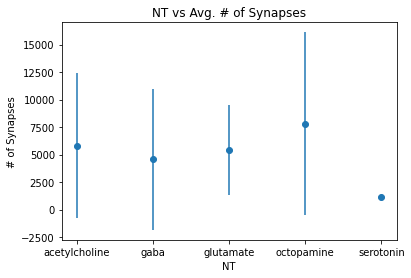

In [229]:
fig, ax = plt.subplots(1)
ax.errorbar(all_means.index, all_means.tot_conns, 
             yerr=all_stds.tot_conns, marker='o', linestyle='None')
ax.set_title('NT vs Avg. # of Synapses')
ax.set_ylabel('# of Synapses')
ax.set_xlabel('NT')

In [230]:
mean_str = [np.mean(np.multiply(pn_annos.conns[i], np.arange(1,100))) 
            for i in pn_annos.index]
pn_annos['mean_str'] = mean_str
# std_str = [np.std(np.multiply(pn_annos.conns[i], np.arange(1,100))) for i in pn_annos.index]
# pn_annos['std_str'] = std_str
saver = pn_annos.copy()

In [234]:
all_means = pn_annos.groupby('NT').mean()
all_stds = pn_annos.groupby('NT').std()

Text(0.5, 0, 'NT')

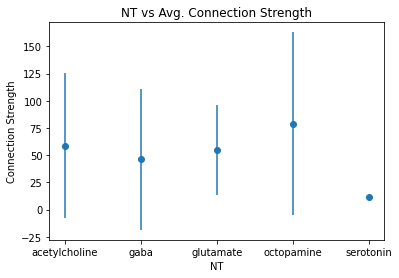

In [236]:
fig, ax = plt.subplots(1)
ax.errorbar(all_means.index, all_means.mean_str, 
             yerr=all_stds.mean_str, marker='o', linestyle='None')
ax.set_title('NT vs Avg. Connection Strength')
ax.set_ylabel('Connection Strength')
ax.set_xlabel('NT')